In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline

## Introduction 

In this example, an event-driven protocol is defined: Once the number of symptomatic infectives exceeds a threshold, the contact matrix is scaled down by a factor 1/4; then, once the number of infectives falls below another threshold, the original contact matrix is restored. For an SIIR model with two age groups, we run this protocol in two variations: First, we allow every event to happen at most one time; in the second run, we allow events to repeat.

*This is the Jupyter notebook version of an example from the PyRoss manual.*

## Define system parameters

In [3]:
import numpy as np; from matplotlib import pyplot as plt; import pyross

# 1. Define model
M  = 2               # the population has two age groups
N  =  5e4            # and this is the total population
# exact params of reference trajectory
beta  = 0.02         # infection rate
gIa   = 1./7         # recovery rate of asymptomatic infectives
gIs   = 1./7         # recovery rate of asymptomatic infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter
# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi
# set up initial condition
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])   # and also symptomatic infectives
R0  = np.array([0, 0])  # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0) # initial number of susceptibles

## Define events that trigger change of contact matrix

In [4]:
# 2. Define events and corresponding contact matrices
C = np.array([[18., 9.], [3., 12.]])
events = []
contactMatrices = []
# For technical reasons, currently the event functions take a
# vector argument "rp" instead of a tuple (S, Ia, Is).
# When defining the event functions, the following correspondence has to be used:
# S  == rp[ :M]
# Ia == rp[1*M:2*M]
# Is == rp[2*M:3*M]
# More generally, for any model the order of the populations within the vector rp is
# the same as used for the initial conditions in the model.simulate() function call.

# Event 0: dummy event used to set the initial contact matrix
events.append( lambda t, rp: 1. )
contactMatrices.append( C )
# Event 1: contact matrix reduces by a factor of 4 once number of symptomatic
# infectives exceeds a threshold (start of lockdown)
lockdown_threshold_on = 2000
def event1(t,rp):
    return np.sum(rp[2*M:3*M]) - lockdown_threshold_on
event1.direction = +1 # we need to pass the threshold from below for the event to happen
events.append(event1); contactMatrices.append( 0.25*C )
# Event 2: original contact matrix is restored once number of symptomatic infectives
# falls below a given threshold (end of lockdown).
lockdown_threshold_off = 50
def event2(t,rp):
    return np.sum(rp[2*M:3*M]) - lockdown_threshold_off
event2.direction = -1 # we need to pass the threshold from above for the event to happen
events.append(event2); contactMatrices.append( C )

## Run simulations and visualise results

Note that we run the simulation twice: 

1. In the first run, each event can only occur once.
1. In the second run, each event can only occur multiple times.

In [5]:
# 3. Run pyross.control simulation twice: Once with events only occuring once, 
# and once with events possibly several times
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'fsa':fsa}
model = pyross.control.SIR(parameters, M, Ni)
# Run simulation
Tf = 300
Nt = (Tf +1)*10
# each event only occurs once
result_1 = model.simulate(S0, Ia0, Is0,events=events,
                          contactMatrices=contactMatrices,
                          Tf=Tf, Nf=Nt)
# events can occur repeatedly
result_2 = model.simulate(S0, Ia0, Is0,events=events,
                          contactMatrices=contactMatrices,
                          events_repeat=True,
                          Tf=Tf, Nf=Nt)

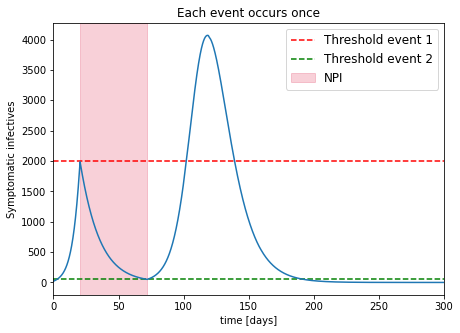

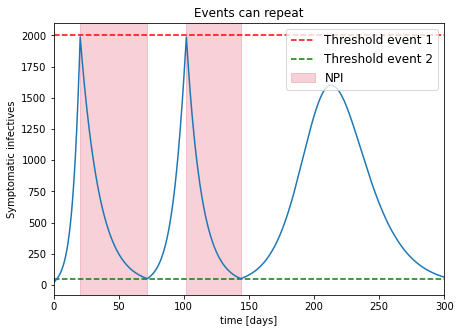

In [7]:
# 4. Visualise results
# First simulation where events only occur once
def plot_result(result,title=None):
    t_arr = result['t']; traj = result['X']
    Is = np.sum(traj[:,2*M:],axis=-1)
    events_occured = result['events_occured']
    #
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    if title != None:
        ax.set_title(title)
    ax.axhline(lockdown_threshold_on,label='Threshold event 1',
              ls='--',color='red')
    ax.axhline(lockdown_threshold_off,label='Threshold event 2',
              ls='--',color='green')
    for i,e in enumerate(events_occured[::2]):
        if 2*i + 1 < len(events_occured):
            if i == 0: 
                label= 'NPI'
            else:
                label= ''
            ax.axvspan(e[0],events_occured[2*i+1][0],
                           label=label,
                          alpha=0.2,color='crimson')
    ax.plot(t_arr,Is)
    ax.set_xlim(np.min(t_arr),np.max(t_arr))
    ax.set_ylabel('Symptomatic infectives'); ax.set_xlabel(r'time [days]')
    ax.legend(loc='upper right',fontsize=12)
    #if title != None:
    #    fig.savefig(title +'.pdf',bbox_inches='tight')
    plt.show(fig); plt.close(fig)

    
plot_result(result_1,title='Each event occurs once')
plot_result(result_2,title='Events can repeat')